## Visualisation of the Feature Engineering Process (via Convolutional Filters)

### Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [14]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random

In [15]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [16]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [17]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

# Load data from Parquet file and convert to strings
data_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [18]:
def normalise_array(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) / (np.max(sub_array) - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

# Apply normalisation to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

print(f"Lengths of first few subarrays in normalised_times: {ak.num(normalised_times, axis=1)[:10]}")
print(f"Example subarray from normalised_times: {normalised_times[0]}")


# Print minimum and length for testing
# print(f"Minimum values of sub-arrays: {[sub_array.min() for sub_array in padded_times]}")
# print(f"Length of sub-array 200: {len(padded_times[200])}")

Lengths of first few subarrays in normalised_times: [1101, 932, 525, 640, 656, 651, 635, 829, 356, 1236]
Example subarray from normalised_times: [0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.996, 0.997, 0.998, 0.999, 1]


# Standardising Length of Data

In [19]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths)
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))

print(f"Length After Padding: {len(padded_times[0])}")
# print(padded_times[0][-200:])

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

Now lets standardise the Sample data

In [20]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")
# print(padded_samples[0][-200:])

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


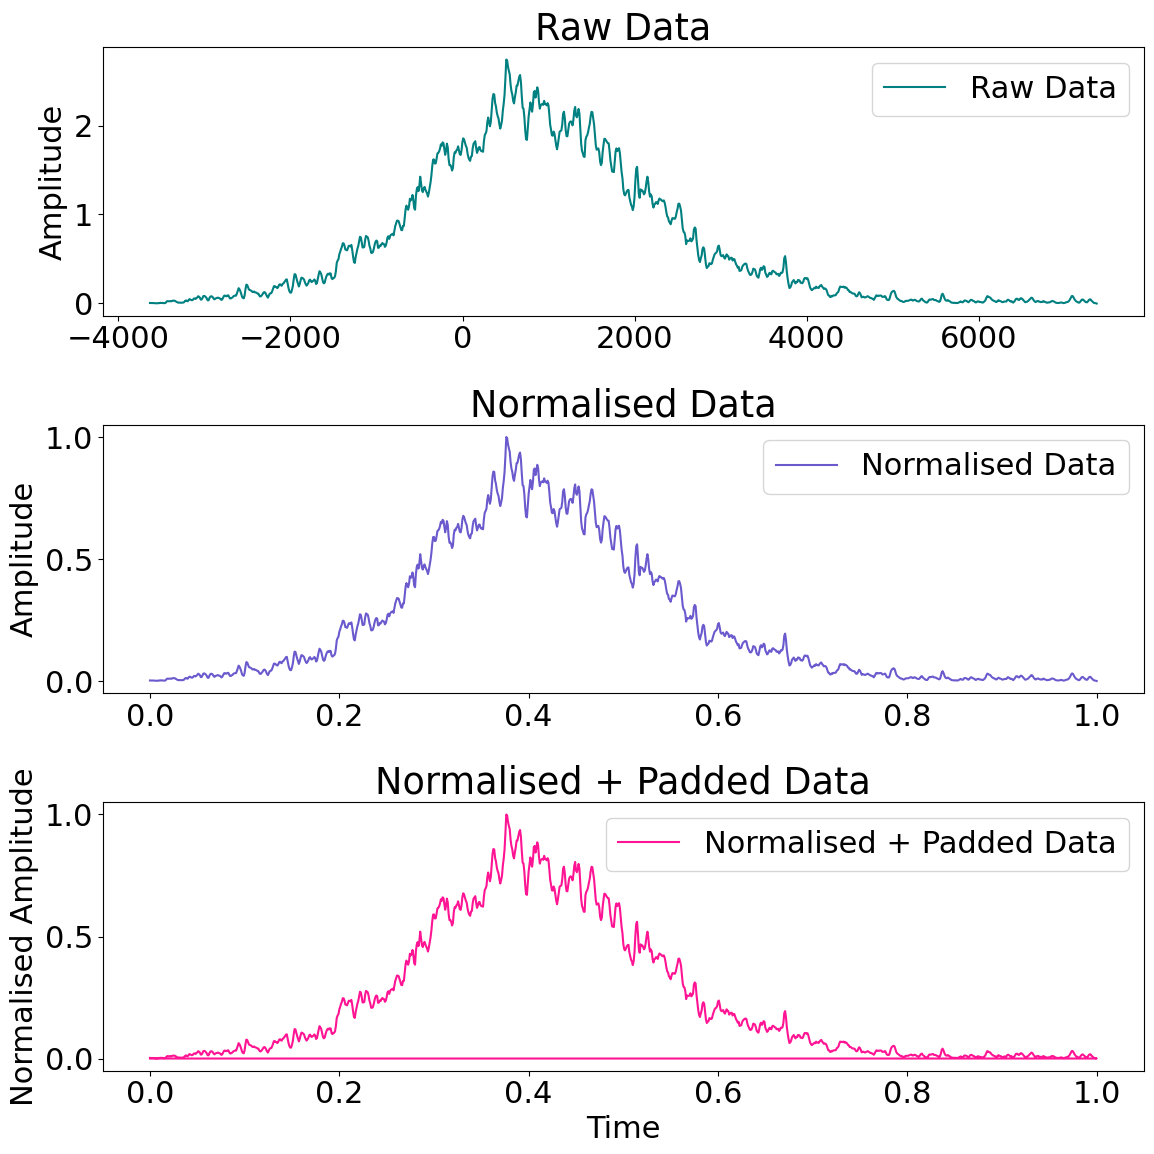

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # axs is an array of Axes

# Plot the first dataset in the first subplot
axs[0].plot(arr['times'][0], arr['samples'][0], label='Raw Data', color='teal')
axs[0].set_title("Raw Data")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot the second dataset in the first subplot
axs[1].plot(normalised_times[0], normalised_samples[0], label='Normalised Data', color='slateblue')
axs[1].set_title("Normalised Data")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

# Plot the third dataset in the second subplot
axs[2].plot(padded_times[0], padded_samples[0], label='Normalised + Padded Data', color='deeppink')
axs[2].set_title("Normalised + Padded Data")
axs[2].set_ylabel("Normalised Amplitude")
axs[2].legend()

# Add overall labels
plt.xlabel("Time")

# Adjust spacing between subplots for readability
plt.tight_layout()

# Show the plot
plt.savefig('Figures/errorsinpaddingandnormalising.png')
plt.show()

# Creating the Training and Test Data (AwkwardArrays)

(7782, 2828)
(7782, 2828)


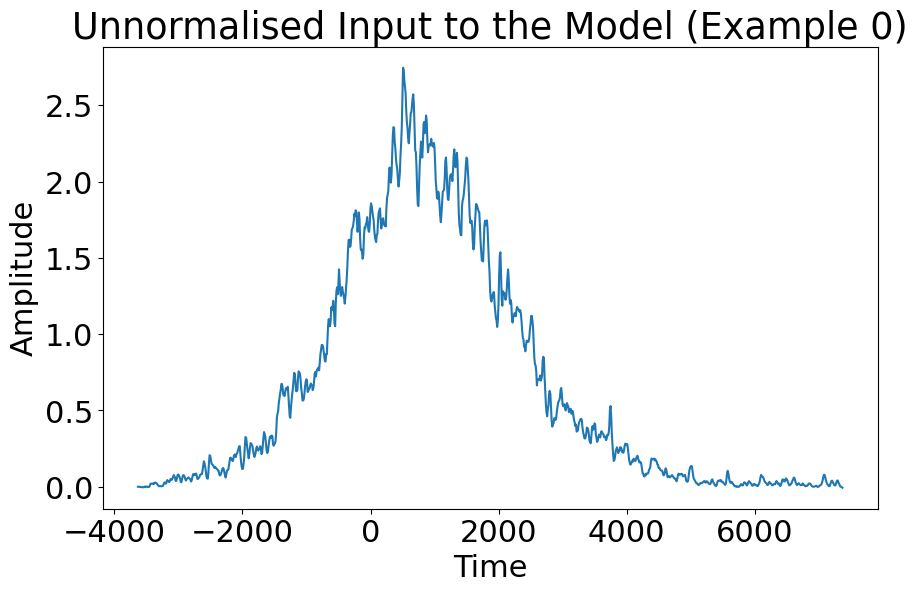

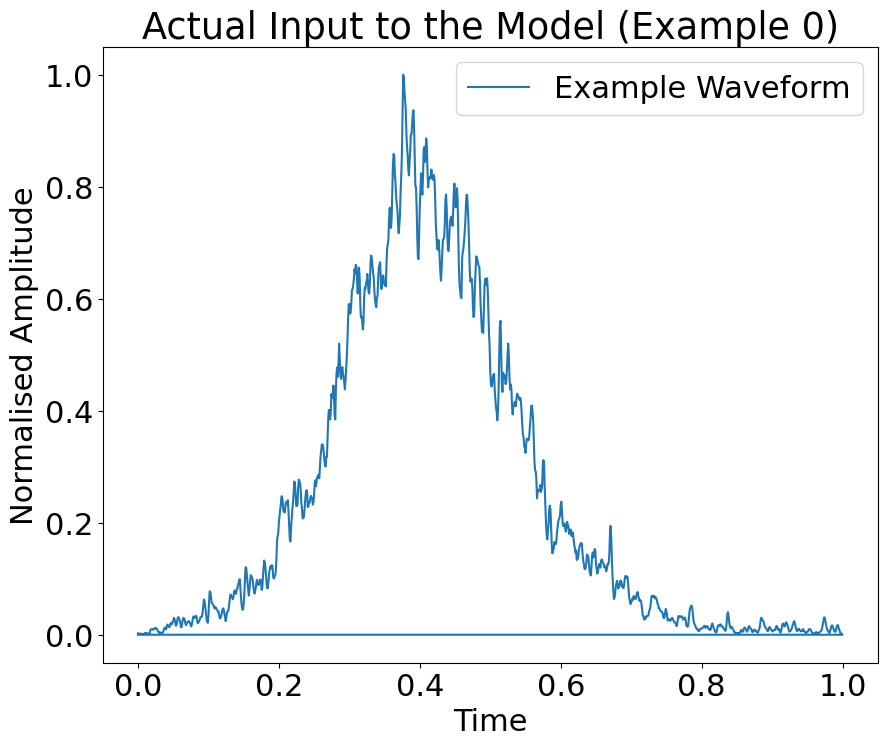

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define padding length
padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded
print(normalised_times_padded.shape)
print(X.shape)

time_steps = normalised_times_padded.shape[1]
example_index = 0
example_row = X[example_index]

# Split the row into time and samples
example_time = normalised_times_padded[example_index][500:-500]  # The time data of sample index {example_index}
example_samples = example_row[500:-500]  # The sample data of sample index {example_index}

plt.figure(figsize=(10, 6))
plt.plot(arr['times'][0], arr['samples'][0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Unnormalised Input to the Model (Example {example_index})")

plt.show()
plt.plot(example_time, example_samples, label="Example Waveform")
plt.xlabel("Time")
plt.ylabel("Normalised Amplitude")
plt.title(f"Actual Input to the Model (Example {example_index})")
plt.legend()
# plt.grid(True)
plt.show()

# S2 Area Spectrum

In [23]:
areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)

print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

305.75293803418805
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   4.  14.  12.  33.  39.  49.  65.  67.  65.  76.  66.  93.  90.
  89. 109.  78. 105.  82. 109.  78.  96.  80. 101. 109.  96.  87.  95.
  95.  83.  86.  96.  84. 101.  82.  70.  79.  81.  78.  67.  96.  77.
  71.  70.  78.  67.  59.  67.  61.  59.  58.  58.  43.  53.  44.  55.
  60.  64.  52.  39.  53.  32.  33.  29.  47.  35.  41.  31.  29.  27.
  24.  37.  24.  23.  24.  19.  17.  18.  18.  15.   9.  21.  14.  26.
  16.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5. 13. 43.
 60. 42. 27. 25. 18. 25. 18. 16. 24. 23. 18. 41. 26. 21. 22. 22. 23. 15.
 22. 20. 19. 16. 19. 17. 15. 14. 13. 16. 17. 33. 11. 31. 11. 22. 19. 16.
 14. 18. 21. 24. 16. 17. 19. 18. 25. 24. 23. 27. 17. 32. 18. 23. 23. 17.
 20. 13. 19. 13. 18. 12. 15. 21. 16. 17. 19. 13. 23. 24. 21. 15. 22. 20.
 18. 32. 22. 12. 16. 13. 13. 19. 11.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

In [24]:
bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])

305.7223627403846
1189.0
0.0
0.0
0.0032545047259652992


# Weighting the S2 Area Spectrum

MAX areas: tritum,gate, cathode, overall dataset (np.float64(17881.375), np.float64(17847.5546875), np.float64(17886.546875), np.float64(17886.546875))
13.411785247523326
37.54691093085141
10.274164346048565
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.4

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_5864/170837472.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_5864/170837472.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_5864/170837472.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_5864/170837472.py:50: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_5864/1

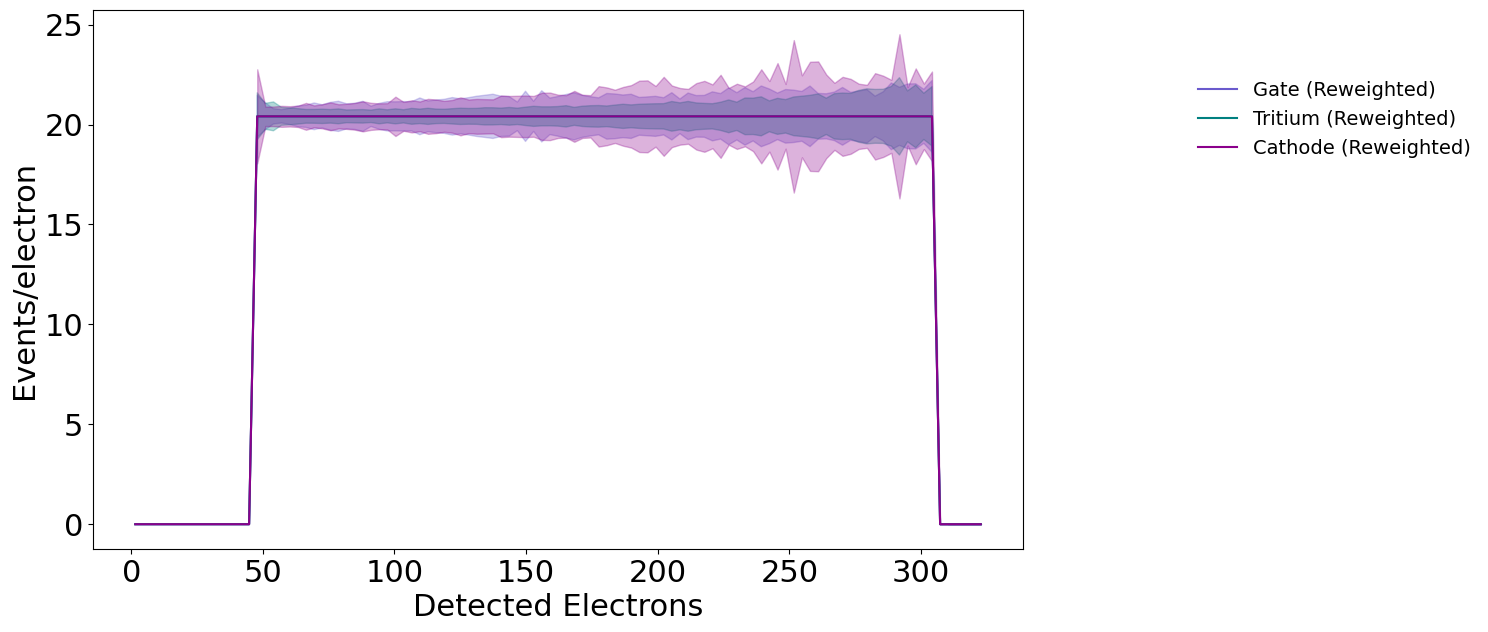

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAX areas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()]) # average integral (area) of each histgoram to be used as reweighting benchmark

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/60 # * (average_counts / cathode_counts.sum())

# PADDING: Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.5,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('Figures/weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [26]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights) # check if values are defined (finite), 0 if not.

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [27]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [28]:
total_weight = ak.sum(arr['weights'])

# Normalize the weights by dividing each element by the total weight
normalized_weights = arr['weights'] / total_weight

# If you want to save the normalized weights back to the array. In Awkward, this is done by duplicating the original array and adding a new column.
arr = ak.with_field(arr, normalized_weights, 'weights_normalized')

print(arr['weights_normalized'])

[0.000543, 2.31e-05, 0.000142, 0.000142, ..., 0.000788, 0.000788, 0.000788]


# Convolutional Neural Network

In [29]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalized'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalized_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: (UNNORMALISED) WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test = train_test_split(
    X, labels, normalized_area, weights_np, test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 2828)
Shape of y_train: (5836,)


In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.01,      # Minimum change in loss to qualify as an improvement
    patience=3,          # Stop training after 3 epochs of no significant improvement
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)

convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=200, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=200, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers. 2D pooled feauture map flattened to 1D vector to input into dense outer layers.
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2) specifies a pooling window which means the layer will take the max value from every 2-linear-unit-wide region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

convoNN.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=5, batch_size=218, validation_split=0.2, verbose=0)

/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Evaluation on Test Data

In [32]:
X_test_reshaped = X_test.reshape(-1, 5656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_padded, y_test, verbose=0)

(973, 5656, 1)


[0.2519490718841553, 0.8987666964530945]

# Visualising the Model Classification Effectiveness: The Probability Distribution

61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step


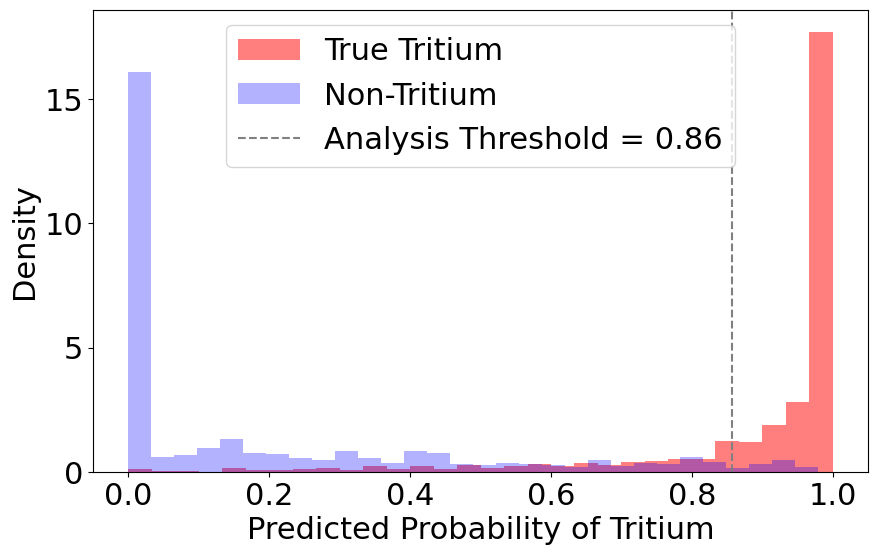

In [33]:
# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test_padded)

predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
# for i in range(30):
    # print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities. All the training examples in the training dataset that the model has predicted to be tritium.

# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2) # actual tritium events
non_tritium_mask = (y_test != 2) # non-tritium(background) events

threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.axvline(x=threshold, color='gray', linestyle='--', label=f'Analysis Threshold = {threshold:.2f}')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.show()

# Visualising the Inputs to the Model

2828
(5836,)
2828
1828
2328


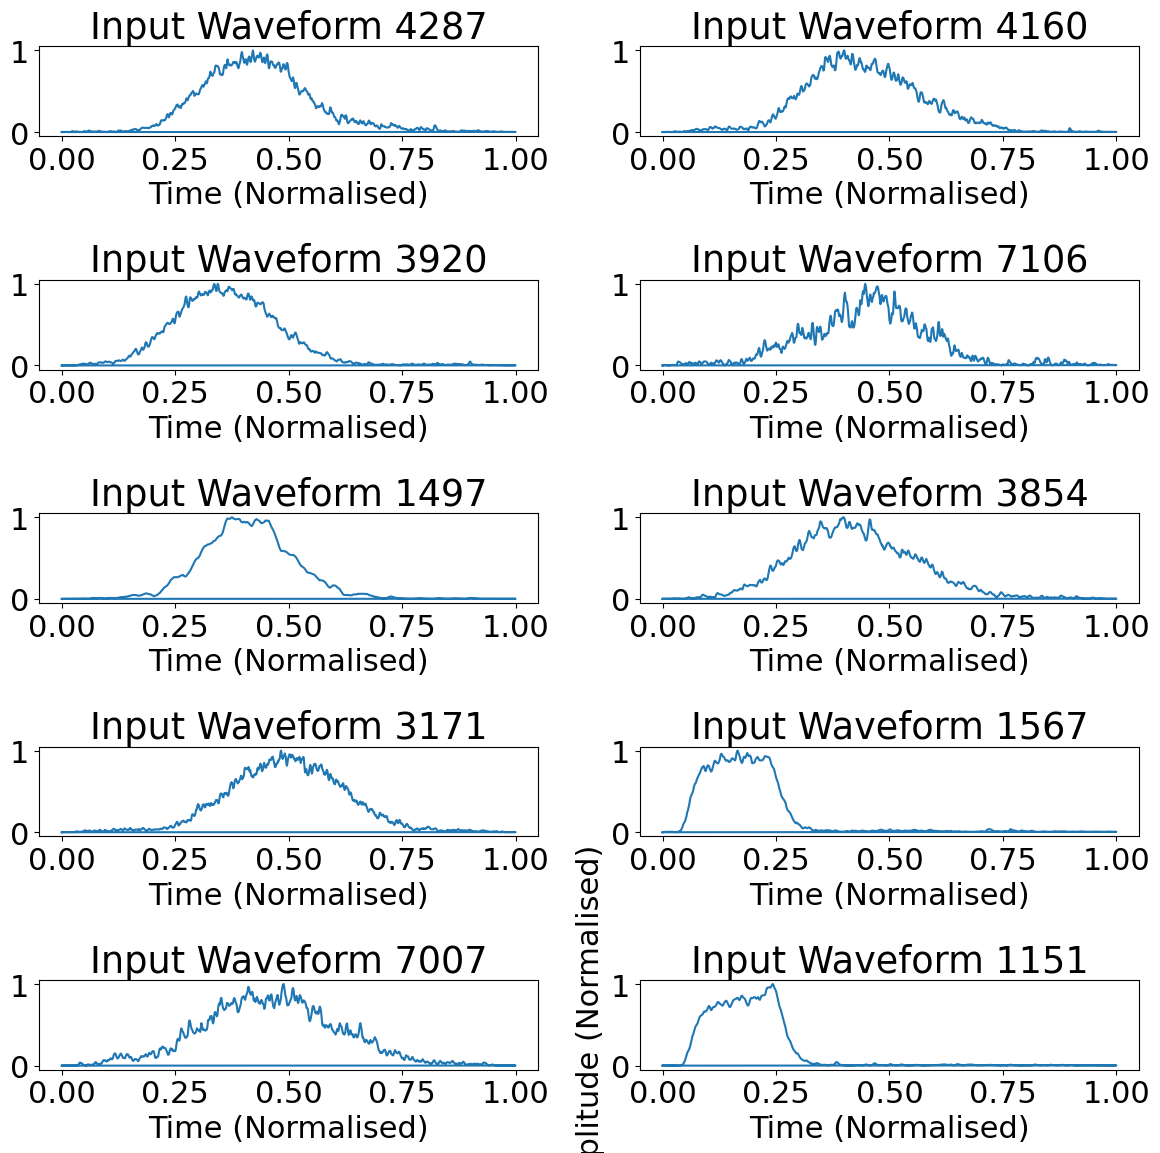

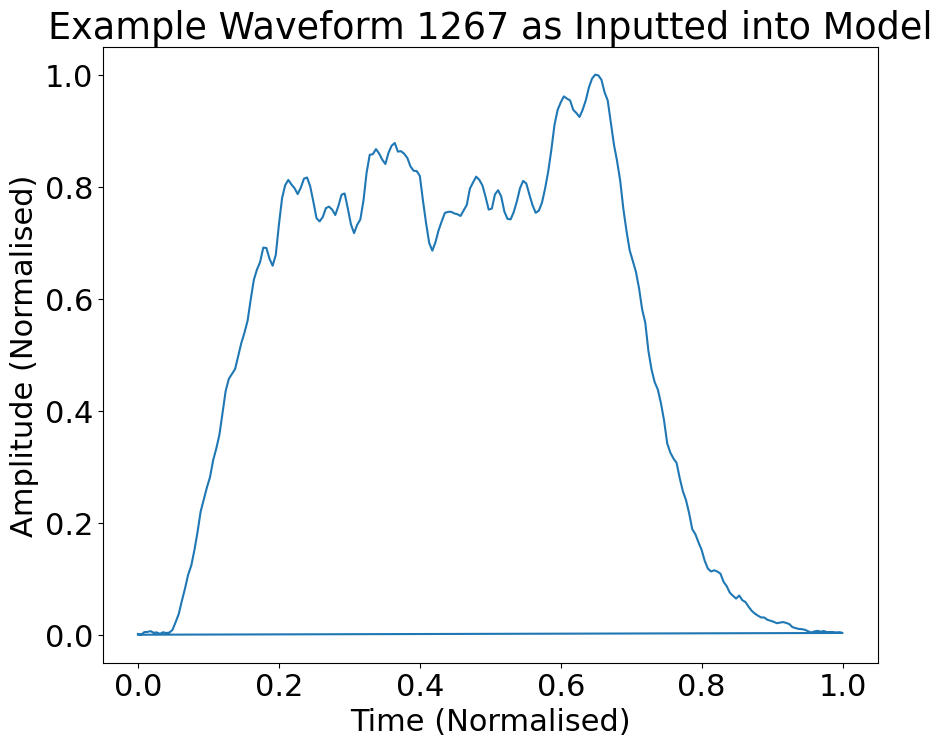

[0. 0. 0. ... 0. 0. 0.]


In [61]:
from tensorflow.keras.models import Model
print(X_train_padded.shape[1])
print(y_train.shape)

# Select every 10^2-th waveform
step = 100  # Step size for selection
waveforms_to_plot = X_train_padded[::step]

num_samples = X_train_padded.shape[1]
print(num_samples)

# Calculate sample length before padding
original_time_sample_length = (num_samples - (2 * padding_length)) #// 2 # floor division (round down to nearest integer)
print(original_time_sample_length)
print(original_time_sample_length + (padding_length))

# Visualize the first 10 padded training examples
# Generate 10 random indices to plot 10 random examples
random_indices = np.random.randint(0, X.shape[0], size=10)

plt.figure(figsize=(12,12))
for idx, i in enumerate(random_indices):  # Iterate through the random indices
    plt.subplot(5, 2, idx + 1)
    plt.plot(normalised_times_padded[i, :], X[i, :])
    plt.title(f"Input Waveform {i}")
    plt.xlabel("Time (Normalised)")
    # plt.ylabel("Amplitude (Normalised)")

plt.ylabel("Amplitude (Normalised)")
plt.tight_layout()
plt.show()

plt.plot(normalised_times_padded[1267][500:-500], X[1267][500:-500]) # X_train padded is just the reshaped version to change the 2D array into 3D format - the format required for CNN input
# plt.scatter(X_train[0][:2828], X_train[0][2828:])
#plt.plot(arr['times'][0], arr['samples'][0])
# plt.plot(X[0][:1828], X_combined[0][1828:])
plt.ylabel("Amplitude (Normalised)")
plt.xlabel("Time (Normalised)")
plt.title('Example Waveform 1267 as Inputted into Model')
plt.show()

print(X[1267])

# Visualising the Feature Maps (Detected Features by the Filters)

To extract numerical feature maps from these layers, we need to create an intermediate model ('feauture_model') and pass real input data through it.
'feauture_model' is a new sub-model that takes the same input as convoNN but outputs intermediate activations (feature maps) from the layers specified in layer_outputs.

In [63]:
# Get intermediate layer outputs
# print(convoNN.layers)

# Assume "model" is your trained model
layer_outputs = [layer.output for layer in convoNN.layers if 'conv' in layer.name]  # Extract Conv1D layers
feature_model = Model(inputs=convoNN.input, outputs=layer_outputs)

# Select a single waveform for feature visualization
sample_waveform = X_test_padded[step].reshape(1, -1, 1)  # Reshape for model input

# Get feature maps from convolutional layers
feature_maps = feature_model.predict(sample_waveform)

# Plot feature maps
for layer_index, fmap in enumerate(feature_maps):
    num_filters = fmap.shape[-1]  # Number of filters in this layer
    plt.figure(figsize=(12, 8))
    for i in range(min(num_filters, 10)):  # Plot up to 10 filters for clarity
        plt.subplot(5, 2, i + 1)
        plt.plot(fmap[0, :, i])
        plt.title(f"Layer {layer_index + 1}, Filter {i + 1}")
        plt.xlabel("Time")
        plt.ylabel("Activation")
    plt.tight_layout()
    plt.show()

AttributeError: The layer sequential has never been called and thus has no defined input.

# FOR TEST RUNS ONLY: Code to stop execution of the notebook

In [ ]:
import sys
sys.exit("Notebook execution stopped.")

SystemExit: Notebook execution stopped.

/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Preliminary Feature Visualisations

In [ ]:
input_data = X_train_padded
from tensorflow.keras.models import Model

# Replace 'conv1d_layer_name' with your actual layer's name
layer_name = 'flatten'
intermediate_model = Model(inputs=convoNN.input, outputs=convoNN.get_layer(layer_name).output)
# Get feature maps
#feature_maps = intermediate_model.predict(input_data)
#print("Feature map shape:", feature_maps.shape)  # Example: (1, 50, 32)
# Extract feature maps for a single input
feature_maps = intermediate_model.predict(input_data)

import matplotlib.pyplot as plt

# Choose one example (e.g., the first sample in the batch)
sample_idx = 32
feature_maps_sample = restricted_feature_maps[sample_idx]  # Shape: (2629, 10)

# Number of filters
num_filters = feature_maps_sample.shape[-1]

# Create subplots: one plot per filter
fig, axes = plt.subplots(num_filters, 1, figsize=(15, num_filters * 2))  # Adjust height for clarity
axes = np.atleast_1d(axes)  # Ensure axes is iterable, even for one filter

# Plot each filter's activation over timesteps
for i in range(num_filters):
    axes[i].plot(range(feature_maps_sample.shape[0]), feature_maps_sample[:, i], color='blue')
    axes[i].set_title(f"Filter {i+1}")
    axes[i].set_xlabel("Timesteps")
    axes[i].set_ylabel("Activation")

plt.tight_layout()
plt.show()



# Plot feature maps
#num_filters = feature_maps.shape[-1]
#timesteps = feature_maps.shape[1]

#fig, axes = plt.subplots(num_filters // 4 + 1, 4, figsize=(15, 10))  # Adjust grid as needed
#axes = axes.flatten()

#for i in range(num_filters):
   # axes[i].plot(range(timesteps), feature_maps[0, :, i])  # First input in batch
   # axes[i].set_title(f"Filter {i+1}")
    #axes[i].set_xlabel("Timesteps")
    #axes[i].set_ylabel("Activation")

# Hide unused subplots
#for j in range(num_filters, len(axes)):
    #axes[j].axis('off')

#plt.tight_layout()
#plt.show()

In [ ]:
convoNN.summary()
# Print layer names
for layer in convoNN.layers:
    print(layer.name)

In [ ]:
# Extract filters from the first convolutional layer (or the desired layer)
filters, _ = convoNN.layers[0].get_weights()

# Normalize filters to [0, 1] for better visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Get the number of filters
num_filters = filters.shape[-1]

# Set the number of filters to display (e.g., first 5 filters)
num_to_display = min(5, num_filters)  # Limits to 5 or the total number of filters

# Plot filters
fig, axes = plt.subplots(1, num_to_display, figsize=(15, 15))

for i in range(num_to_display):
    ax = axes[i]
    ax.imshow(filters[:, :, i], cmap='viridis')  # For 2D filters (height, width, num_filters)
    ax.axis('off')
    ax.set_title(f'Filter {i+1}')

plt.show()